In [52]:
import networkx as nx
import numpy as np
import itertools
import json
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = "svg"

In [53]:
def createPreferenceGraph(n, maxPreferencesPerCategory) :
    strings = ["prefers to collaborate with", "prefers to socialize with", "avoids to collaborate with",
           "avoids to socialize with", "perceives that the node ? prefers to collaborate with him", 
           "perceives that the node ? prefers to socialize with him", 
           "perceives that the node ? avoids to collaborate with him", 
           "perceives that the node ? avoids to socialize with him"]
    
    def editString(s, node1, node2) :
        if "?" in s :
            return f"node {node1} {str(node2).join(s.split('?'))}"
        else :
            return f"node {node1} {s} node {node2}"

    G = nx.DiGraph()
    G.add_nodes_from(range(n))

    for node in G.nodes() :
        # possible peers are everyone expect for current node
        nodes = list(filter(lambda item : item != node, G.nodes()))

        # get 8 numbers randomly
        # each one represent how many answers the current node has given for a question
        numberOfChoices = np.random.choice(range(1, maxPreferencesPerCategory + 1), size=8)

        # pick up some distinct nodes
        neighbors = np.random.choice(nodes, sum(numberOfChoices), replace=False)
        
        stringIndex = 0
        count = 0
        for arr in np.split(neighbors, list(itertools.accumulate(numberOfChoices))[:-1]) :
            for element in arr :
                count += 1
                G.add_edge(int(node), int(element), opinion=editString(strings[stringIndex], node, element))
            stringIndex += 1
        assert count == len(neighbors), "Something bad happened.... Be careful with the sizes"
    return G

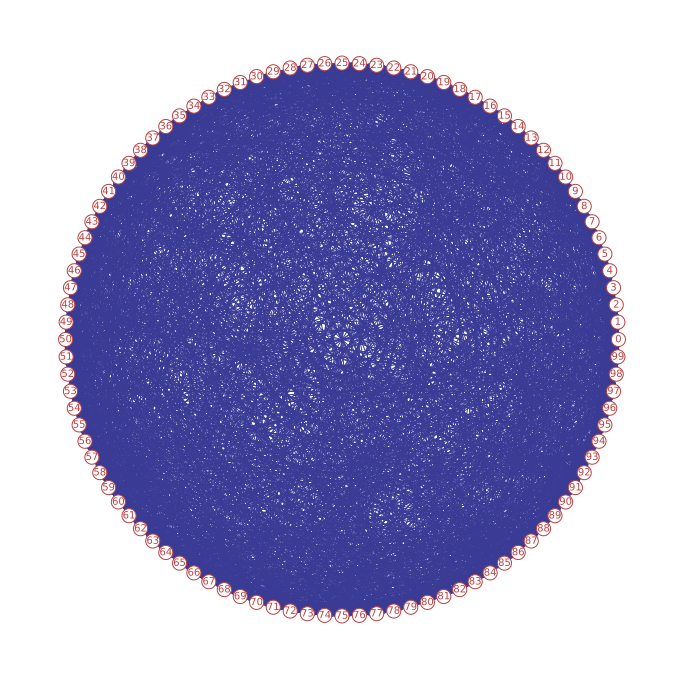

In [54]:
options = {
    "n" : 100, # number of students
    "maxPreferencesPerCategory" : 5 # max number of student's preferences for a quiz question
}

G = createPreferenceGraph(**options)

plt.figure(figsize=(12,12))
plt.axis('equal')
options = {
            "node_color": "white",
            "edgecolors": "#b94042",
            "linewidths": 1,
            "node_size": 200,
            "edge_color": "#3a3b95",
            "font_size": 10,
            "font_color": '#b94042'
            }
nx.draw_circular(G, with_labels=True, **options)

In [55]:
for u, v, data in G.edges(data=True):
    print(data["opinion"])

node 0 prefers to collaborate with node 93
node 0 prefers to collaborate with node 26
node 0 prefers to collaborate with node 72
node 0 prefers to collaborate with node 66
node 0 prefers to collaborate with node 99
node 0 prefers to socialize with node 14
node 0 avoids to collaborate with node 74
node 0 avoids to socialize with node 16
node 0 avoids to socialize with node 42
node 0 avoids to socialize with node 63
node 0 avoids to socialize with node 3
node 0 avoids to socialize with node 73
node 0 perceives that the node 5 prefers to collaborate with him
node 0 perceives that the node 78 prefers to collaborate with him
node 0 perceives that the node 43 prefers to socialize with him
node 0 perceives that the node 60 avoids to collaborate with him
node 0 perceives that the node 83 avoids to collaborate with him
node 0 perceives that the node 67 avoids to collaborate with him
node 0 perceives that the node 13 avoids to collaborate with him
node 0 perceives that the node 15 avoids to coll

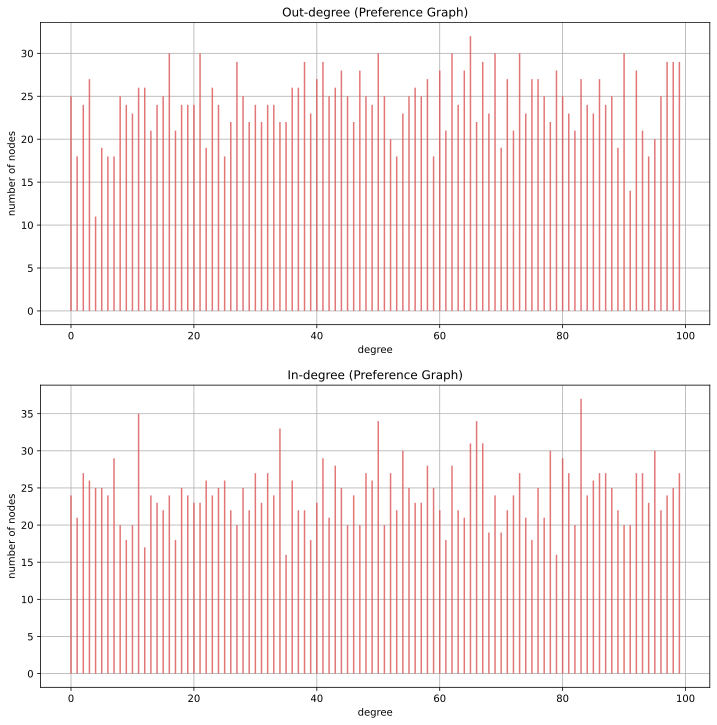

In [56]:
fig, ax = plt.subplots(2, 1, figsize=(12,12))
degrees = [dict(G.out_degree()), dict(G.in_degree())]

for i in range(2) :
    ax[i].vlines(x=list(degrees[i].keys()), ymin=0, ymax=list(degrees[i].values()), color="#DB5454", alpha=0.8)
    ax[i].grid(True)
    ax[i].set_title(f"{['Out-degree', 'In-degree'][i]} (Preference Graph)")
    ax[i].set_xlabel("degree")
    ax[i].set_ylabel("number of nodes")

In [57]:
def saveGraphJson(G, path) :
    def convertToJSON(G) :
        nodes = [{"id": node} for node in G.nodes()]
        
        edges = [{
            "source": i,
            "target": j,
            "opinion": data["opinion"]
        } for i, j, data in G.edges(data=True)]

        return {
            "nodes": nodes,
            "edges": edges
        }
    with open(path, "w") as write_file:
        json.dump(convertToJSON(G), write_file)


In [58]:
saveGraphJson(G, "./preferenceGraph.json")

In [59]:
import re
from collections import Counter

Counter({1: 497, 0: 479, 0.3: 473, 0.7: 447, 0.5: 68, 0.15: 45, 0.85: 40, 0.65: 37, 0.35: 37})


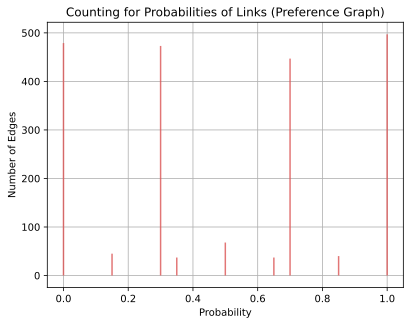

In [60]:
def calculateProbability(weight) :
    if re.match(r".*perceives.*prefers.*collaborate.*|.*perceives.*prefers.*socialize.*", weight) :
        return 0.7
    elif re.match(r".*perceives.*avoids.*collaborate.*|.*perceives.*avoids.*socialize.*", weight) :
        return 0.3
    elif re.match(r".*prefers.*collaborate.*|.*prefers.*socialize.*", weight) :
        return 1
    else :
        return 0
        

#dictionary {edge : probability of existing in the Preference Graph}
edgesProbabilities = {}

#examine each eage in Preference Graph
#calculate probability
for u, v in G.edges() :
    if G.has_edge(v, u) :
    #(u,v) and (v,u) are checked together once
        if (v,u) in edgesProbabilities :
            #(v,u) is already checked, so neglect (u,v)
            continue 
        else :
            #(u,v), (v,u) pair has not been checked
            edgesProbabilities[(u,v)] = 0.5*(calculateProbability(G[u][v]["opinion"]) + calculateProbability(G[v][u]["opinion"]))
    else :
        edgesProbabilities[(u,v)] = calculateProbability(G[u][v]["opinion"])


fig, ax = plt.subplots()
count = Counter(edgesProbabilities.values())
print(count)
ax.vlines(x=list(count.keys()), ymin=0, ymax=list(count.values()), color="#DB5454", alpha=0.8)
ax.grid(True)
ax.set_title(f"Counting for Probabilities of Links (Preference Graph)")
ax.set_xlabel("Probability")
ax.set_ylabel("Number of Edges")
plt.show()